<img src="https://www.alse.fr/sites/alse.fr/local/cache-vignettes/L400xH350/deeplearning-fbdab.jpg?1573310057" />

###  Computer vision & classification d'images du dataset Fashion Mnist à l'aide de réseaux de neuronnes

# <span style="color:lime"> Présentation </span>

Ce notebook met en oeuvre la classification d'images (10 classes) à l'aide de différentes architectures de réseaux de neuronnes 

La démarche a été réalisée de manière itérative par entraînements sucessifs de "nouveaux modèles":


1.   **DNN** : Feedforward Deep Neural Network
2.   **CNN** : Convolutional Neural Network
3.   **Tunning & Optimisation** : des hyperparamètres des DNN & CNN à l'aide d'un Gridsearch
4.   **Transfer learning** : Utilisation de modèles pré-entrainnés greffés sur les DNN & CNN optimisés

**Le Dataset Fashion MNIST**

Fashion MNIST est un jeu de données de qui contient 70 000 images en niveaux de gris répartie sur 1 des 10 catégories. Les images montrent des vêtements, d'articles de Zalando , en basse résolution (28 x 28 pixels). La base de données est repartie en un ensemble de 60.000 exemples de formation et d'un ensemble de 10.000 exemples de test Cette base de données vise à remplacer le jeu de données MNIST (de chiffres écrit à la main) plus assez complexe dans une logique d'apprentissage automatique.

-----------------------------
-----------------------------
-----------------------------

# 1.<span style="color:red"> Librairies </span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import visualkeras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model

from tensorflow.keras.optimizers import *

from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

from time import time

%matplotlib inline

In [2]:
 print(tf.__version__)

2.6.0


# 2.<span style="color:green"> Datasets </span>

In [3]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
labels_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

### 2.1<span style="color:black">  EDA </span>

In [4]:
print(f'train_images Shape:{train_images.shape}  & train_labels Shape:{train_labels.shape}');
print(f'test_images Shape:{test_images.shape}  & test_labels Shape:{test_labels.shape}')

train_images Shape:(60000, 28, 28)  & train_labels Shape:(60000,)
test_images Shape:(10000, 28, 28)  & test_labels Shape:(10000,)


label: 1  Trouser


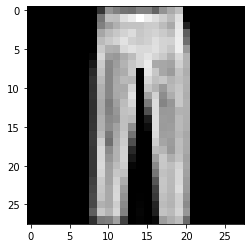

In [5]:
i = 16
plt.gray()
plt.imshow(train_images[i])
print(f'label: {train_labels[i]}  {labels_names[train_labels[i]]}')

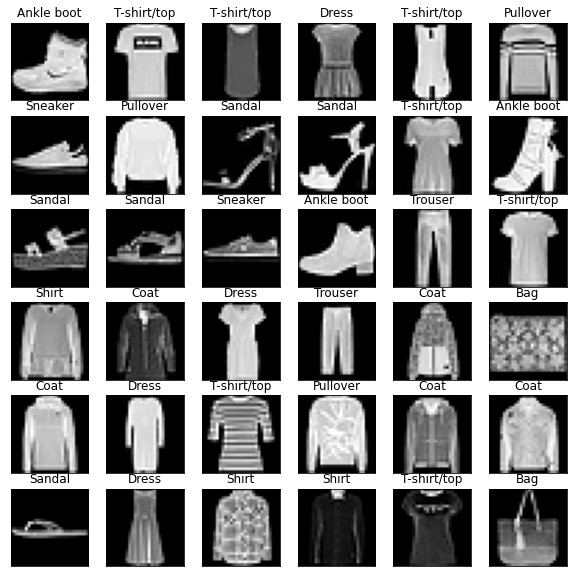

In [6]:
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape((28,28)))
    label_index = int(train_labels[i])
    plt.title(labels_names[label_index])

# 3.<span style="color:blue"> Preprocessing </span>

**Instanciation d'une graine à 16 pour le générateur de nombres aléatoires.**

In [7]:
np.random.seed(16)
tf.random.set_seed(16)

**Split du set de validation à partir du Train set**

In [8]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, 
                                                                      train_labels, 
                                                                      test_size=0.2,
                                                                      random_state=16)

In [9]:
print(f'train_images Shape:{train_images.shape}  & train_labels Shape:{train_labels.shape}');
print(f'val_images Shape:{val_images.shape}  & val_labels Shape:{val_labels.shape}');
print(f'test_images Shape:{test_images.shape}  & test_labels Shape:{test_labels.shape}')

train_images Shape:(48000, 28, 28)  & train_labels Shape:(48000,)
val_images Shape:(12000, 28, 28)  & val_labels Shape:(12000,)
test_images Shape:(10000, 28, 28)  & test_labels Shape:(10000,)


#### 3.1 Preprocessing pour les réseaux DNN

- **Rescaling des images et transformation en un vecteur de taille 784 = (28 pixels * 28 pixels)**

In [10]:
X_train_dnn =train_images.reshape(train_images.shape[0],784)
X_train_dnn = X_train_dnn.astype('float32')/255
y_train_dnn = to_categorical(train_labels)

X_val_dnn =val_images.reshape(val_images.shape[0],784)
X_val_dnn = X_val_dnn.astype('float32')/255
y_val_dnn = to_categorical(val_labels)

X_test_dnn =test_images.reshape(test_images.shape[0],784)
X_test_dnn = X_test_dnn.astype('float32')/255
y_test_dnn = to_categorical(test_labels)

#### 3.2 Preprocessing pour les réseaux CNN

- **Vectorisation et normalisation des données et l'ajout du canal (B)**

In [11]:
X_train_cnn =train_images.reshape(train_images.shape[0],28,28,1)
X_train_cnn = X_train_cnn.astype('float32')/255
y_train_cnn = to_categorical(train_labels)

X_val_cnn =val_images.reshape(val_images.shape[0],28,28,1)
X_val_cnn = X_val_cnn.astype('float32')/255
y_val_cnn = to_categorical(val_labels)

X_test_cnn =test_images.reshape(test_images.shape[0],28,28,1)
X_test_cnn = X_test_cnn.astype('float32')/255
y_test_cnn = to_categorical(test_labels)

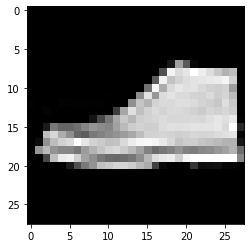

In [12]:
plt.imshow(X_train_cnn[1605]);

#### 3.3 Preprocessing pour les modèles de Transfer Learning

- **Rescaling, Conversion en tenseurs & Ajout des canaux (RGB)**

In [13]:
train_images =train_images.reshape(train_images.shape[0],28,28,1)
train_images = train_images.astype('float32')
y_train_tl = to_categorical(train_labels)

val_images =val_images.reshape(val_images.shape[0],28,28,1)
val_images = val_images.astype('float32')
y_val_tl = to_categorical(val_labels)

test_images =test_images.reshape(test_images.shape[0],28,28,1)
test_images = test_images.astype('float32')
y_test_tl = to_categorical(test_labels)

In [14]:
%%time

# Conversion du dataset en 3 canaux RGB
X_train_tl = tf.image.grayscale_to_rgb(tf.convert_to_tensor(train_images),name=None)

X_val_tl = tf.image.grayscale_to_rgb(tf.convert_to_tensor(val_images),name=None)

X_test_tl = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_images),name=None)

Wall time: 145 ms


In [15]:
%%time

from keras.preprocessing.image import img_to_array, array_to_img

X_train_tl = np.asarray([img_to_array(array_to_img(im, scale=False).resize((75,75))) for im in X_train_tl])
X_val_tl = np.asarray([img_to_array(array_to_img(im, scale=False).resize((75,75))) for im in X_val_tl])
X_test_tl = np.asarray([img_to_array(array_to_img(im, scale=False).resize((75,75))) for im in X_test_tl])

Wall time: 4min 44s


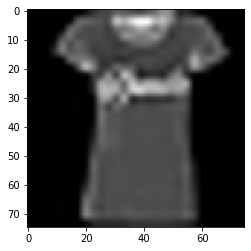

In [16]:
plt.imshow(X_train_tl[77].astype('uint8'));

# 4.<span style="color:darkorange"> Modélisation </span>

**Ce callback crée aura pour role d'arrêter l'entrainnement lorsque l'accuracy sur le set de validation atteindra 93%**

In [17]:
from tensorflow.keras import callbacks

class stop_train(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get("val_accuracy")>0.93):
            print("\n Validation accuracy supérieure à 93%")
            self.model.stop_training = True

**Ce callback crée aura pour role d'arrêter l'entrainnement lorsque la loss function lors de l'entrainement se dégrade et ne diminue plus**

In [18]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',
                    mode='min',
                    patience = 5,
                    verbose=1,
                    restore_best_weights=True)

In [19]:
cb1 = stop_train()
cb2 = es

### 4.1<span style="color:black">  Feedforward Deep Neural Network </span>

#### 4.1.a Modèle DNN n°1

Ce réseau est constitué par 4 couches Denses avec les propriétés suivantes: 
 - 128 neurones activation relu
 - 64 neurones activation relu
 - 28 neurones activation relu
 - 10 neuronnes de sortie activation softmax

L'algorithme d'optimisation est de type SGD avec un `learning_rate = 0.01, momentum = 0.9, nesterov = True`

La loss utilisée : `'categorical_crossentropy'` 

La métrique utilisée : `"accuracy"`

La modèle sera entrainé sur 15 epochs avec un batch size de 64

In [20]:
dnn_1 = models.Sequential([
    layers.Dense(128, activation="relu", input_shape=(784,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(28, activation="relu"),
    layers.Dense(10, activation="softmax")
])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 28)                1820      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                290       
Total params: 110,846
Trainable params: 110,846
Non-trainable params: 0
_________________________________________________________________


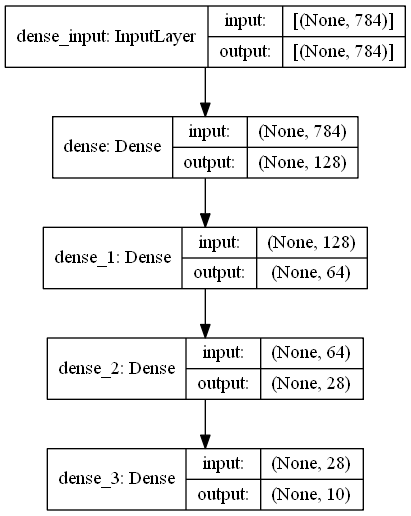

In [21]:
# model summary
dnn_1.summary()

plot_model(dnn_1, show_shapes = True)

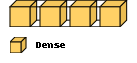

In [22]:
visualkeras.layered_view(dnn_1, legend = True)

In [23]:
%%time
keras.backend.clear_session()
# compile the model
optim = optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True) # optimization with stochastic gradient descent
dnn_1.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
nb_epochs = 15

# training
history_dnn_1 = dnn_1.fit(X_train_dnn, y_train_dnn, 
                          epochs= nb_epochs, batch_size = 64, 
                          validation_data = (X_val_dnn, y_val_dnn),
                          callbacks = [cb1,cb2])

Epoch 1/15
750/750 [==============================] - 2s 2ms/step - loss: 0.5971 - accuracy: 0.7915 - val_loss: 0.4624 - val_accuracy: 0.8398
Epoch 2/15
750/750 [==============================] - 2s 2ms/step - loss: 0.4062 - accuracy: 0.8564 - val_loss: 0.3857 - val_accuracy: 0.8638
Epoch 3/15
750/750 [==============================] - 1s 2ms/step - loss: 0.3680 - accuracy: 0.8660 - val_loss: 0.3635 - val_accuracy: 0.8702
Epoch 4/15
750/750 [==============================] - 1s 2ms/step - loss: 0.3409 - accuracy: 0.8758 - val_loss: 0.3467 - val_accuracy: 0.8728
Epoch 5/15
750/750 [==============================] - 1s 2ms/step - loss: 0.3246 - accuracy: 0.8806 - val_loss: 0.3809 - val_accuracy: 0.8577
Epoch 6/15
750/750 [==============================] - 2s 2ms/step - loss: 0.3082 - accuracy: 0.8861 - val_loss: 0.3300 - val_accuracy: 0.8825
Epoch 7/15
750/750 [==============================] - 2s 2ms/step - loss: 0.2923 - accuracy: 0.8908 - val_loss: 0.3371 - val_accuracy: 0.8796
Epoch 

In [24]:
# model evaluation
(loss_dnn1, accuracy_dnn1) = dnn_1.evaluate(X_test_dnn, y_test_dnn)

print(f'Loss :{loss_dnn1} , accuracy: {accuracy_dnn1}')

313/313 [==============================] - 0s 1ms/step - loss: 0.3837 - accuracy: 0.8705
Loss :0.38372066617012024 , accuracy: 0.8705000281333923


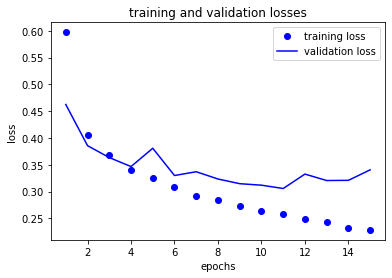

In [25]:
training_loss = history_dnn_1.history['loss']
validation_loss = history_dnn_1.history['val_loss']

epochs = range(1,len(training_loss)+1)
plt.plot(epochs,training_loss, 'bo', label='training loss')
plt.plot(epochs,validation_loss, 'b', label='validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('training and validation losses')
plt.legend()
plt.show()
# The training loss indicates how well the model is fitting the training data
# The validation loss indicates how well the model fits new data.

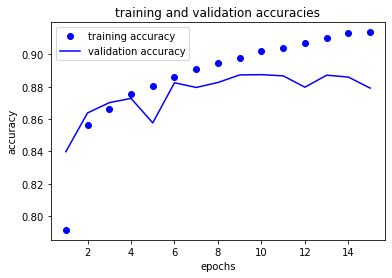

In [26]:
training_accuracy = history_dnn_1.history['accuracy']
validation_accuracy = history_dnn_1.history['val_accuracy']

epochs = range(1,len(training_accuracy)+1)
plt.plot(epochs,training_accuracy, 'bo', label='training accuracy')
plt.plot(epochs,validation_accuracy, 'b', label='validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.title('training and validation accuracies')
plt.legend()
plt.show()

#### 4.1.b Modèle DNN n°2

Ce réseau est constitué par 3 couches Denses avec les propriétés suivantes: 
 - 128 neurones activation relu
 - 64 neurones activation relu
 - 10 neuronnes de sortie activation softmax

L'algorithme d'optimisation est de type Adam

La loss utilisée : `'categorical_crossentropy'` 

La métrique utilisée : `"accuracy"`

La modèle sera entrainé sur 15 epochs avec un batch size de 64

In [27]:
dnn_2 = models.Sequential([
    layers.Dense(128, activation="relu", input_shape=(784,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

dnn_2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

nb_epochs = 15

In [28]:
%%time
keras.backend.clear_session()

dnn_2.fit(X_train_dnn, y_train_dnn,
          epochs= nb_epochs,batch_size=64,
          validation_data = (X_val_dnn, y_val_dnn),
         callbacks = [cb1,cb2])

Epoch 1/15
750/750 [==============================] - 2s 2ms/step - loss: 0.5300 - accuracy: 0.8149 - val_loss: 0.4748 - val_accuracy: 0.8290
Epoch 2/15
750/750 [==============================] - 2s 2ms/step - loss: 0.3860 - accuracy: 0.8611 - val_loss: 0.3732 - val_accuracy: 0.8665
Epoch 3/15
750/750 [==============================] - 2s 2ms/step - loss: 0.3471 - accuracy: 0.8727 - val_loss: 0.3486 - val_accuracy: 0.8755
Epoch 4/15
750/750 [==============================] - 1s 2ms/step - loss: 0.3180 - accuracy: 0.8830 - val_loss: 0.3602 - val_accuracy: 0.8646
Epoch 5/15
750/750 [==============================] - 1s 2ms/step - loss: 0.2997 - accuracy: 0.8890 - val_loss: 0.3463 - val_accuracy: 0.8736
Epoch 6/15
750/750 [==============================] - 2s 2ms/step - loss: 0.2850 - accuracy: 0.8931 - val_loss: 0.3243 - val_accuracy: 0.8837
Epoch 7/15
750/750 [==============================] - 1s 2ms/step - loss: 0.2705 - accuracy: 0.8994 - val_loss: 0.3215 - val_accuracy: 0.8854
Epoch 

In [29]:
# model evaluation
(loss_dnn2, accuracy_dnn2) = dnn_2.evaluate(X_test_dnn, y_test_dnn)

print(f'Loss :{loss_dnn2} , accuracy: {accuracy_dnn2}')

313/313 [==============================] - 0s 944us/step - loss: 0.3763 - accuracy: 0.8755
Loss :0.37625548243522644 , accuracy: 0.8755000233650208


**Notons qu'il n y a presque pas d'améliorations sur l'accuracy entre les deux modèles**

In [30]:
print(f'Loss_dnn1 :{loss_dnn1} , accuracy_dnn1: {accuracy_dnn1}');

print(f'Loss_dnn2 :{loss_dnn2} , accuracy_dnn2: {accuracy_dnn2}')

Loss_dnn1 :0.38372066617012024 , accuracy_dnn1: 0.8705000281333923
Loss_dnn2 :0.37625548243522644 , accuracy_dnn2: 0.8755000233650208


In [31]:
predictions = dnn_2.predict(X_test_dnn)
predict_labels = []
for pred in predictions:
    predict_labels.append(np.argmax(pred))

In [32]:
y_labels = []
for pred in y_test_dnn:
    y_labels.append(np.argmax(pred))

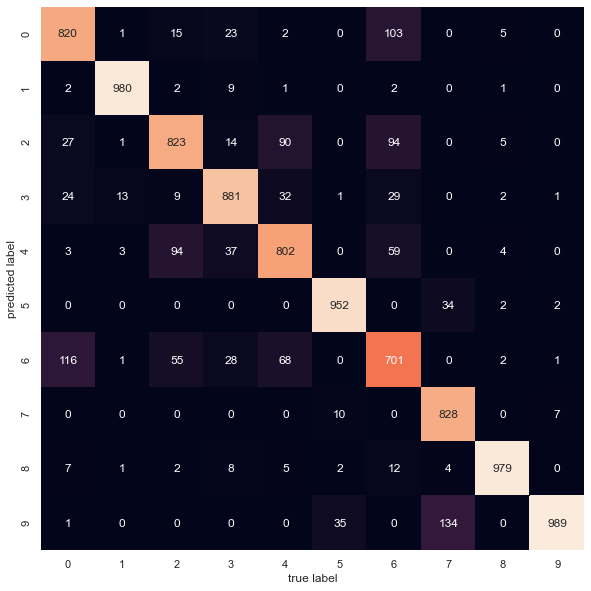

In [33]:
from sklearn.metrics import classification_report,confusion_matrix

mat = confusion_matrix(y_labels, predict_labels)
plt.figure(figsize=(10, 10))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_labels),
            yticklabels=np.unique(y_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show();

In [34]:
import pandas as pd

class_report_v = classification_report(predict_labels,y_labels, output_dict=True,target_names=labels_names,zero_division=1)
pd.DataFrame(class_report_v).T

,precision,recall,f1-score,support
T-shirt/top,0.820000,0.846233,0.832910,969.0000
Trouser,0.980000,0.982949,0.981472,997.0000
Pullover,0.823000,0.780835,0.801363,1054.0000
Dress,0.881000,0.888105,0.884538,992.0000
Coat,0.802000,0.800399,0.801199,1002.0000
Sandal,0.952000,0.961616,0.956784,990.0000
Shirt,0.701000,0.721193,0.710953,972.0000
Sneaker,0.828000,0.979882,0.897561,845.0000
Bag,0.979000,0.959804,0.969307,1020.0000
Ankle boot,0.989000,0.853322,0.916165,1159.0000


### 4.2<span style="color:black">  Convolutional Neural Network </span>

Ce réseau est constitué par: 
 - Couches de convolution 2D `Conv2D`
 - Couches de MaxPooling 2D `MaxPooling2D`
 - Une couche pour aplatir l'input `Flatten`
 - Une couche pour normaliser l'input `BatchNormalization`
 - Une couche dense 512 neurones activation relu
 - Une couche dense 10 neuronnes de sortie activation softmax
 

L'algorithme d'optimisation est de type RMSprop

La loss utilisée : `'categorical_crossentropy'` 

La métrique utilisée : `"accuracy"`

La modèle sera entrainé sur 15 epochs avec un batch size de 64

In [35]:
model_cnn = models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu',kernel_initializer='he_normal', input_shape=(28,28, 1)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')

])

In [36]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0

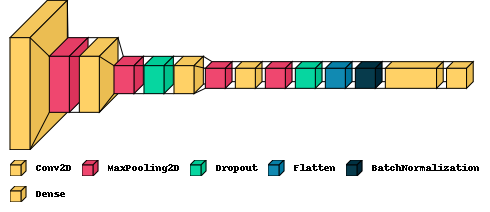

In [37]:
visualkeras.layered_view(model_cnn, legend = True)

In [38]:
model_cnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
%%time
keras.backend.clear_session()

nb_epochs = 15
history_cnn = model_cnn.fit(X_train_cnn, y_train_cnn,
                        epochs= 15, batch_size = 64, 
                        validation_data=(X_val_cnn, y_val_cnn),
                        callbacks = [cb1,cb2])

Epoch 1/15
750/750 [==============================] - 36s 47ms/step - loss: 0.4956 - accuracy: 0.8179 - val_loss: 0.3634 - val_accuracy: 0.8687
Epoch 2/15
750/750 [==============================] - 36s 48ms/step - loss: 0.3475 - accuracy: 0.8742 - val_loss: 0.3230 - val_accuracy: 0.8838
Epoch 3/15
750/750 [==============================] - 37s 49ms/step - loss: 0.2999 - accuracy: 0.8903 - val_loss: 0.3119 - val_accuracy: 0.8921
Epoch 4/15
750/750 [==============================] - 37s 50ms/step - loss: 0.2738 - accuracy: 0.9013 - val_loss: 0.2461 - val_accuracy: 0.9112
Epoch 5/15
750/750 [==============================] - 37s 49ms/step - loss: 0.2549 - accuracy: 0.9067 - val_loss: 0.2311 - val_accuracy: 0.9187
Epoch 6/15
750/750 [==============================] - 37s 49ms/step - loss: 0.2363 - accuracy: 0.9151 - val_loss: 0.2309 - val_accuracy: 0.9181
Epoch 7/15
750/750 [==============================] - 37s 49ms/step - loss: 0.2231 - accuracy: 0.9192 - val_loss: 0.2426 - val_accuracy:

In [40]:
# model evaluation
(loss_cnn, accuracy_cnn) = model_cnn.evaluate(X_test_cnn, y_test_cnn)

print(f'Loss :{loss_cnn} , accuracy: {accuracy_cnn}')

313/313 [==============================] - 2s 8ms/step - loss: 0.2283 - accuracy: 0.9230
Loss :0.22826731204986572 , accuracy: 0.9229999780654907


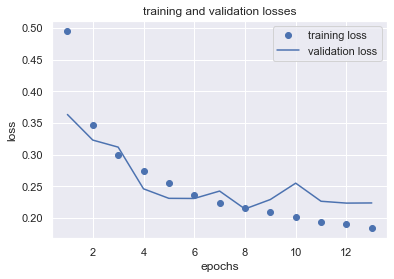

In [41]:
training_loss = history_cnn.history['loss']
validation_loss = history_cnn.history['val_loss']

epochs = range(1,len(training_loss)+1)
plt.plot(epochs,training_loss, 'bo', label='training loss')
plt.plot(epochs,validation_loss, 'b', label='validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('training and validation losses')
plt.legend()
plt.show()

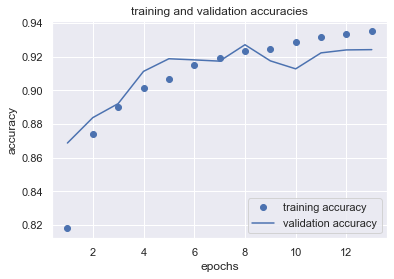

In [42]:
training_accuracy = history_cnn.history['accuracy']
validation_accuracy = history_cnn.history['val_accuracy']

epochs = range(1,len(training_accuracy)+1)
plt.plot(epochs,training_accuracy, 'bo', label='training accuracy')
plt.plot(epochs,validation_accuracy, 'b', label='validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.title('training and validation accuracies')
plt.legend()
plt.show()

In [43]:
predictions = model_cnn.predict(X_test_cnn)
predict_labels = []
for pred in predictions:
    predict_labels.append(np.argmax(pred))

In [44]:
y_labels = []
for pred in y_test_cnn:
    y_labels.append(np.argmax(pred))

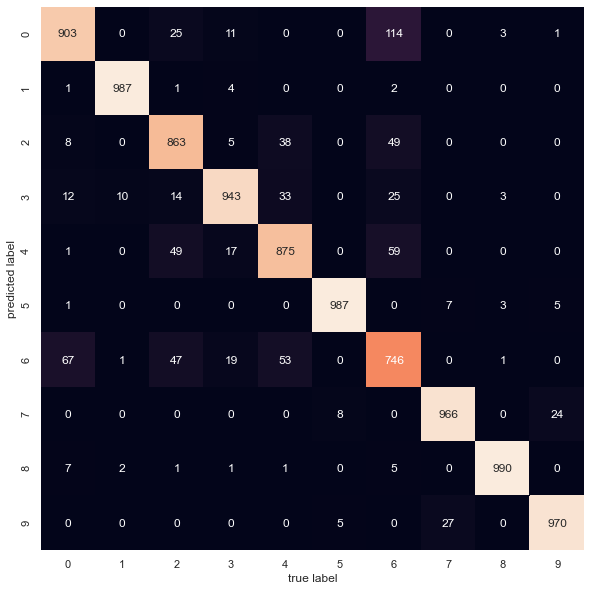

In [45]:
mat = confusion_matrix(y_labels, predict_labels)
plt.figure(figsize=(10, 10))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_labels),
            yticklabels=np.unique(y_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show();

In [46]:
class_report_v = classification_report(predict_labels,y_labels, output_dict=True,target_names=labels_names,zero_division=1)
pd.DataFrame(class_report_v).T

,precision,recall,f1-score,support
T-shirt/top,0.903000,0.854305,0.877978,1057.000
Trouser,0.987000,0.991960,0.989474,995.000
Pullover,0.863000,0.896158,0.879266,963.000
Dress,0.943000,0.906731,0.924510,1040.000
Coat,0.875000,0.874126,0.874563,1001.000
Sandal,0.987000,0.984048,0.985522,1003.000
Shirt,0.746000,0.798715,0.771458,934.000
Sneaker,0.966000,0.967936,0.966967,998.000
Bag,0.990000,0.983118,0.986547,1007.000
Ankle boot,0.970000,0.968064,0.969031,1002.000


# 5.<span style="color:violet"> Tunning des modèles & des hyperparamètres </span>

### 5.1<span style="color:black">  Optimisation d'un modèle DNN </span>

In [47]:
!pip install keras_tuner

In [48]:
import keras_tuner as kt
from tensorflow.keras.optimizers import *

In [49]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

In [50]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

In [51]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

In [52]:
#Hyperband
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=15,
                     factor=3
                     )

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [53]:
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [54]:
%%time

tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Le nombre optimal de neuronnes dans la première couche dense : {best_hps.get('units')} 
et le learning_rate optimal pour l'optimizeur Adam est {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

Le nombre optimal de neuronnes dans la première couche dense : 480 
et le learning_rate optimal pour l'optimizeur Adam est 0.001.

Wall time: 1e+03 µs


In [55]:
%%time
keras.backend.clear_session()

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(img_train, label_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4971 - accuracy: 0.8238 - val_loss: 0.3877 - val_accuracy: 0.8592
Epoch 2/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3687 - accuracy: 0.8646 - val_loss: 0.3581 - val_accuracy: 0.8687
Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3295 - accuracy: 0.8786 - val_loss: 0.3376 - val_accuracy: 0.8786
Epoch 4/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3054 - accuracy: 0.8877 - val_loss: 0.3420 - val_accuracy: 0.8773
Epoch 5/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2843 - accuracy: 0.8949 - val_loss: 0.3363 - val_accuracy: 0.8799
Epoch 6/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2703 - accuracy: 0.8985 - val_loss: 0.3259 - val_accuracy: 0.8844
Epoch 7/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2536 - accuracy: 0.9052 - val_loss: 0.3187 - val_accuracy:

In [56]:
%%time
keras.backend.clear_session()

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/26
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4971 - accuracy: 0.8240 - val_loss: 0.3863 - val_accuracy: 0.8606
Epoch 2/26
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3676 - accuracy: 0.8652 - val_loss: 0.3563 - val_accuracy: 0.8711
Epoch 3/26
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3290 - accuracy: 0.8792 - val_loss: 0.3417 - val_accuracy: 0.8778
Epoch 4/26
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3046 - accuracy: 0.8883 - val_loss: 0.3469 - val_accuracy: 0.8749
Epoch 5/26
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2845 - accuracy: 0.8955 - val_loss: 0.3411 - val_accuracy: 0.8773
Epoch 6/26
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2717 - accuracy: 0.8984 - val_loss: 0.3267 - val_accuracy: 0.8829
Epoch 7/26
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2541 - accuracy: 0.9046 - val_loss: 0.3267 - val_accuracy:

In [57]:
# model evaluation
(loss_dnn_kt, accuracy_dnn_kt) = hypermodel.evaluate(img_test, label_test)

print(f'Loss :{loss_dnn_kt} , accuracy: {accuracy_dnn_kt}')

313/313 [==============================] - 1s 2ms/step - loss: 0.3998 - accuracy: 0.8911
Loss :0.39976516366004944 , accuracy: 0.8910999894142151


### 5.2<span style="color:black">  Optimisation d'un modèle CNN </span>

In [58]:
from keras_tuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

C:\Users\eloue\AppData\Local\Temp/ipykernel_10580/3902227083.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [59]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

img_train=img_train.reshape(len(img_train),28,28,1)
img_test=img_test.reshape(len(img_test),28,28,1)

In [60]:
def build_model(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=(28,28,1)),
    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    # output layer    
    keras.layers.Dense(10, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [61]:
keras.backend.clear_session()

tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,
                          directory='output',project_name="Mnist Fashion")

INFO:tensorflow:Reloading Oracle from existing project output\Mnist Fashion\oracle.json
INFO:tensorflow:Reloading Tuner from output\Mnist Fashion\tuner0.json


In [62]:
tuner_search.search(img_train,label_train,epochs=3,validation_split=0.1)

INFO:tensorflow:Oracle triggered exit


In [63]:
model=tuner_search.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 48)        480       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 48)        20784     
_________________________________________________________________
flatten (Flatten)            (None, 27648)             0         
_________________________________________________________________
dense (Dense)                (None, 48)                1327152   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                490       
Total params: 1,348,906
Trainable params: 1,348,906
Non-trainable params: 0
_________________________________________________________________


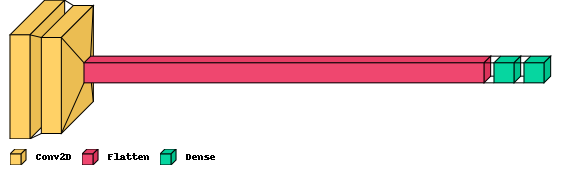

In [64]:
model.summary()
visualkeras.layered_view(model, legend = True)

In [65]:
%%time
keras.backend.clear_session()

model.fit(img_train, label_train, epochs=10, validation_split=0.1, initial_epoch=3)

Epoch 4/10
1688/1688 [==============================] - 73s 43ms/step - loss: 0.1767 - accuracy: 0.9335 - val_loss: 0.3547 - val_accuracy: 0.8848
Epoch 5/10
1688/1688 [==============================] - 73s 43ms/step - loss: 0.1381 - accuracy: 0.9492 - val_loss: 0.4151 - val_accuracy: 0.8875
Epoch 6/10
1688/1688 [==============================] - 73s 43ms/step - loss: 0.1191 - accuracy: 0.9572 - val_loss: 0.4251 - val_accuracy: 0.8898
Epoch 7/10
1688/1688 [==============================] - 70s 42ms/step - loss: 0.0970 - accuracy: 0.9652 - val_loss: 0.4727 - val_accuracy: 0.8773
Epoch 8/10
1688/1688 [==============================] - 70s 42ms/step - loss: 0.0820 - accuracy: 0.9709 - val_loss: 0.4906 - val_accuracy: 0.8888
Epoch 9/10
1688/1688 [==============================] - 71s 42ms/step - loss: 0.0721 - accuracy: 0.9750 - val_loss: 0.5803 - val_accuracy: 0.8890
Epoch 10/10
1688/1688 [==============================] - 71s 42ms/step - loss: 0.0619 - accuracy: 0.9790 - val_loss: 0.6796 

In [66]:
# model evaluation
(loss_cnn_kt, accuracy_cnn_kt) = model.evaluate(img_test, label_test)

print(f'Loss :{loss_cnn_kt} , accuracy: {accuracy_cnn_kt}')

313/313 [==============================] - 3s 9ms/step - loss: 0.7649 - accuracy: 0.8838
Loss :0.7649160623550415 , accuracy: 0.8838000297546387


# 6.<span style="color:lime"> Transfer Learning Models </span>

**La même architecture de couches denses sera gréffée sur 2 modèles de Transfer Learning**

 - Une couche pour aplatir l'input `Flatten`
 - Une couche pour normaliser l'input `BatchNormalization`
 - 128 neurones activation relu
 - 64 neurones activation relu
 - 10 neuronnes de sortie activation softmax

L'algorithme d'optimisation est de type Adam

La loss utilisée : `'categorical_crossentropy'` 

La métrique utilisée : `"accuracy"`

La modèle sera entrainé sur 10 epochs avec un batch size de 32

### 6.1 INCEPTION V3

**Le premier modèle de transfer learning utilisé sera l'Inception v3**


**c'est un réseau de neurones convolutifs pour aider à l'analyse d'images et à la détection d'objets, et a fait ses débuts en tant que module pour Googlenet. Il s'agit de la troisième édition du réseau de neurones convolutifs Inception de Google, initialement présenté lors du défi de reconnaissance ImageNet**

In [67]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_v3 = InceptionV3(input_shape=(75, 75, 3), include_top=False, weights="imagenet")

In [68]:
last_layer = inception_v3.get_layer('mixed7')
last_output = last_layer.output

In [69]:
x = keras.layers.Flatten()(last_output)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(10, activation='softmax')(x)

model_v3 = Model(inception_v3.input, x)

model_v3.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

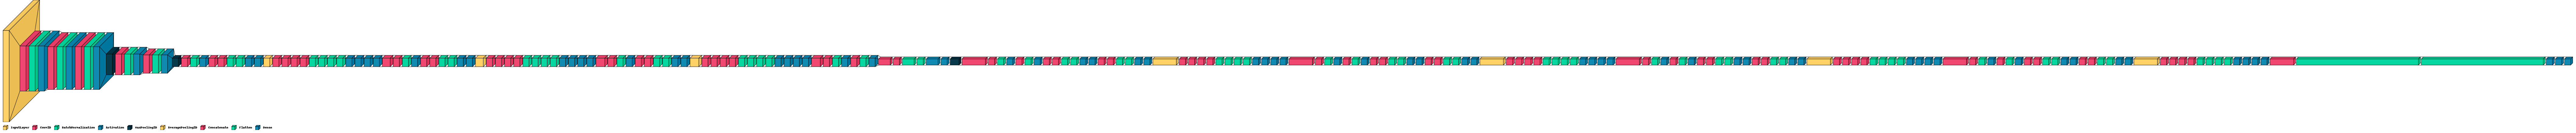

In [70]:
visualkeras.layered_view(model_v3, legend = True)

In [71]:
%%time
keras.backend.clear_session()


history_v3 = model_v3.fit(X_train_tl, y_train_tl, batch_size=32, 
                    epochs=10, # one forward/backward pass of training data
                    validation_data=(X_val_tl, y_val_tl),
                    callbacks = [cb1,cb2])

Epoch 1/10
1500/1500 [==============================] - 2669s 2s/step - loss: 0.4138 - accuracy: 0.8577 - val_loss: 0.6012 - val_accuracy: 0.8737
Epoch 2/10
1500/1500 [==============================] - 862s 575ms/step - loss: 0.2803 - accuracy: 0.9017 - val_loss: 0.2688 - val_accuracy: 0.9103
Epoch 3/10
1500/1500 [==============================] - 862s 574ms/step - loss: 0.2399 - accuracy: 0.9154 - val_loss: 0.3634 - val_accuracy: 0.8726
Epoch 4/10
1500/1500 [==============================] - 912s 608ms/step - loss: 0.2187 - accuracy: 0.9247 - val_loss: 0.2441 - val_accuracy: 0.9145
Epoch 5/10
1500/1500 [==============================] - 880s 586ms/step - loss: 0.2066 - accuracy: 0.9291 - val_loss: 0.2533 - val_accuracy: 0.9078
Epoch 6/10
1500/1500 [==============================] - 817s 545ms/step - loss: 0.1739 - accuracy: 0.9380 - val_loss: 0.2177 - val_accuracy: 0.9239
Epoch 7/10
1500/1500 [==============================] - 811s 541ms/step - loss: 0.1626 - accuracy: 0.9425 - val_lo

In [72]:
%%time

# model evaluation
(loss_v3, accuracy_v3) = model_v3.evaluate(X_test_tl, y_test_tl)

print(f'Loss :{loss_v3} , accuracy: {accuracy_v3}')

313/313 [==============================] - 31s 97ms/step - loss: 0.2188 - accuracy: 0.9244
Loss :0.2187713086605072 , accuracy: 0.9243999719619751
Wall time: 31.1 s


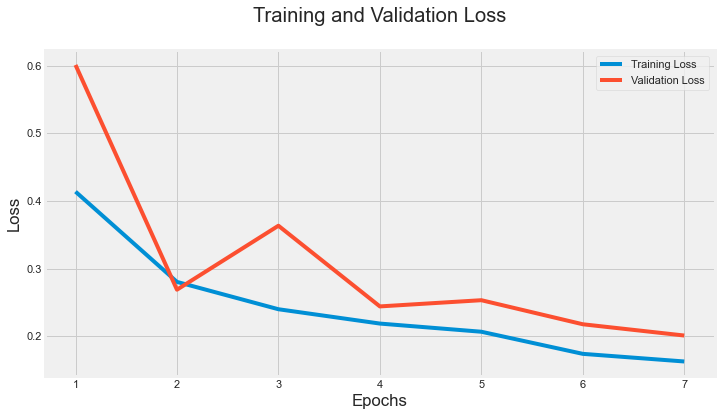

Wall time: 361 ms


In [73]:
%%time

plt.figure(figsize = (12, 6))
plt.style.use('fivethirtyeight')

train_loss = history_v3.history['loss']
val_loss = history_v3.history['val_loss'] 
epoch = range(1, len(train_loss)+1)
sns.lineplot(x=epoch, y=train_loss, label = 'Training Loss')
sns.lineplot(x=epoch, y=val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.show()

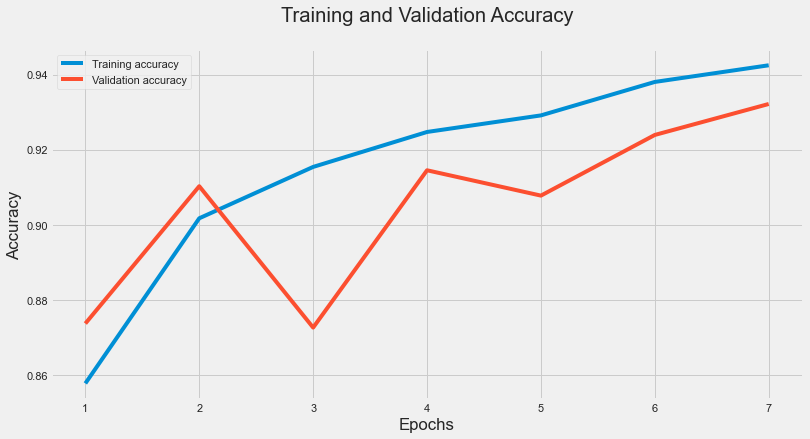

Wall time: 250 ms


In [74]:
%%time

plt.figure(figsize = (12, 6))

train_loss = history_v3.history['accuracy']
val_loss = history_v3.history['val_accuracy'] 
epoch = range(1, len(train_loss)+1)
sns.lineplot(x=epoch, y=train_loss, label = 'Training accuracy')
sns.lineplot(x=epoch, y=val_loss, label = 'Validation accuracy')
plt.title('Training and Validation Accuracy\n')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

In [75]:
predictions = model_v3.predict(X_test_tl)
predict_labels = []
for pred in predictions:
    predict_labels.append(np.argmax(pred))

In [76]:
y_labels = []
for pred in y_test_tl:
    y_labels.append(np.argmax(pred))

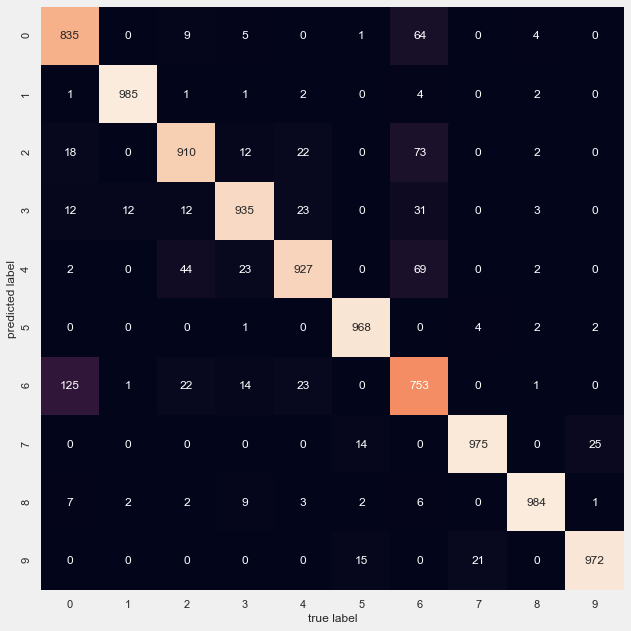

In [77]:
mat = confusion_matrix(y_labels, predict_labels)
plt.figure(figsize=(10, 10))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_labels),
            yticklabels=np.unique(y_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show();

In [78]:
class_report_v = classification_report(predict_labels,y_labels, output_dict=True,target_names=labels_names,zero_division=1)
pd.DataFrame(class_report_v).T

,precision,recall,f1-score,support
T-shirt/top,0.835000,0.909586,0.870699,918.0000
Trouser,0.985000,0.988956,0.986974,996.0000
Pullover,0.910000,0.877531,0.893471,1037.0000
Dress,0.935000,0.909533,0.922091,1028.0000
Coat,0.927000,0.868791,0.896952,1067.0000
Sandal,0.968000,0.990788,0.979262,977.0000
Shirt,0.753000,0.801917,0.776689,939.0000
Sneaker,0.975000,0.961538,0.968222,1014.0000
Bag,0.984000,0.968504,0.976190,1016.0000
Ankle boot,0.972000,0.964286,0.968127,1008.0000


### 6.2 VGG19

**VGG19 est une variante du modèle VGG qui se compose de 19 couches (16 couches de convolution, 3 couches entièrement connectées, 5 couches MaxPool et 1 couche SoftMax).VGG19 compte 19,6 milliards d'hyperparametres entrainnables.**

In [79]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (75, 75, 3), classes = 10)

for layer in vgg19.layers:
    layer.trainable = False

In [80]:
last_layer = vgg19.get_layer("block5_pool")
last_output = last_layer.output

In [81]:
x = keras.layers.Flatten()(last_output)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(10, activation='softmax')(x)

model_vgg19 = Model(vgg19.input, x)

model_vgg19.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0     

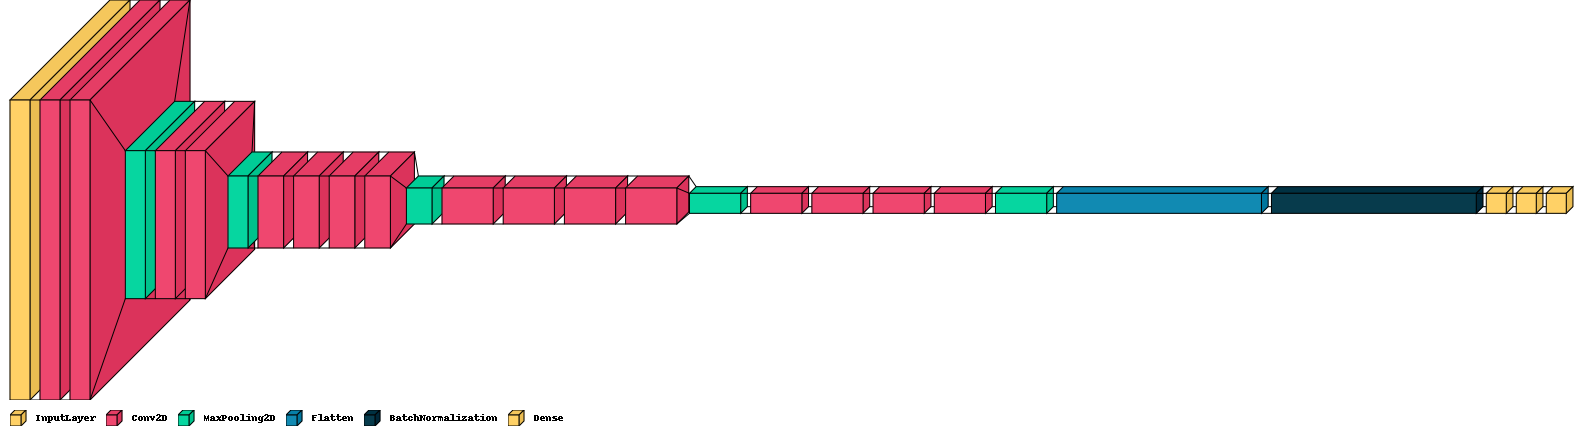

In [82]:
model_vgg19.summary()
visualkeras.layered_view(model_vgg19, legend = True)

In [83]:
%%time
keras.backend.clear_session()
# fitting model

history_vgg19 = model_vgg19.fit(X_train_tl, y_train_tl, batch_size=32, 
                    epochs=10, # one forward/backward pass of training data
                    validation_data=(X_val_tl, y_val_tl),
                    callbacks = [cb1,cb2])

Epoch 1/10
1500/1500 [==============================] - 6903s 5s/step - loss: 0.4302 - accuracy: 0.8465 - val_loss: 0.3819 - val_accuracy: 0.8719
Epoch 2/10
1500/1500 [==============================] - 1459s 973ms/step - loss: 0.3034 - accuracy: 0.8874 - val_loss: 0.4064 - val_accuracy: 0.8777
Epoch 3/10
1500/1500 [==============================] - 1394s 930ms/step - loss: 0.2549 - accuracy: 0.9038 - val_loss: 0.4568 - val_accuracy: 0.8717
Epoch 4/10
1500/1500 [==============================] - 1429s 953ms/step - loss: 0.2201 - accuracy: 0.9168 - val_loss: 0.4871 - val_accuracy: 0.8698
Epoch 5/10
1500/1500 [==============================] - 1468s 979ms/step - loss: 0.1907 - accuracy: 0.9295 - val_loss: 0.5095 - val_accuracy: 0.8701
Epoch 6/10
1500/1500 [==============================] - 1448s 966ms/step - loss: 0.1662 - accuracy: 0.9368 - val_loss: 0.5939 - val_accuracy: 0.8702
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping
Wall time: 3h 55min 2s


In [84]:
%%time

# model evaluation
(loss_vgg19, accuracy_vgg19) = model_vgg19.evaluate(X_test_tl, y_test_tl)

print(f'Loss :{loss_vgg19} , accuracy: {accuracy_vgg19}')

313/313 [==============================] - 234s 748ms/step - loss: 0.3886 - accuracy: 0.8650
Loss :0.38864463567733765 , accuracy: 0.8650000095367432
Wall time: 3min 54s


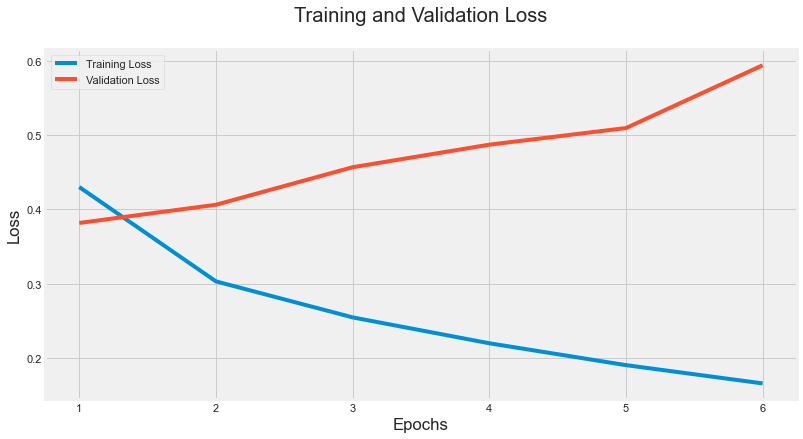

Wall time: 283 ms


In [85]:
%%time

plt.figure(figsize = (12, 6))
plt.style.use('fivethirtyeight')

train_loss = history_vgg19.history['loss']
val_loss = history_vgg19.history['val_loss'] 
epoch = range(1, len(train_loss)+1)
sns.lineplot(x=epoch, y=train_loss, label = 'Training Loss')
sns.lineplot(x=epoch, y=val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.show()

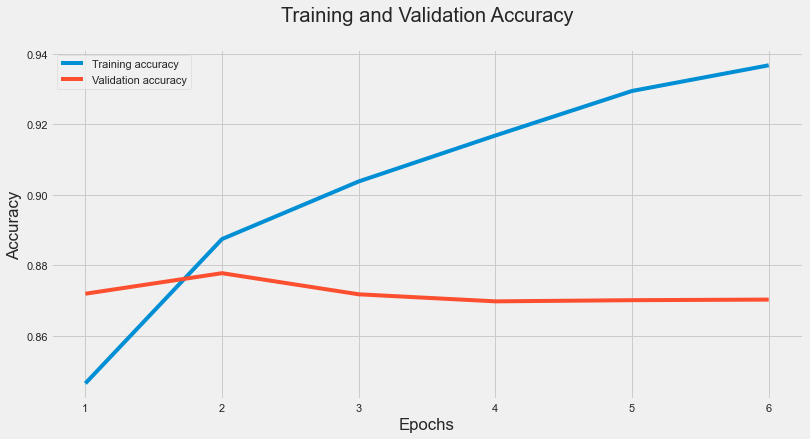

Wall time: 244 ms


In [86]:
%%time

plt.figure(figsize = (12, 6))

train_loss = history_vgg19.history['accuracy']
val_loss = history_vgg19.history['val_accuracy'] 
epoch = range(1, len(train_loss)+1)
sns.lineplot(x=epoch, y=train_loss, label = 'Training accuracy')
sns.lineplot(x=epoch, y=val_loss, label = 'Validation accuracy')
plt.title('Training and Validation Accuracy\n')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

In [87]:
predictions = model_vgg19.predict(X_test_tl)
predict_labels = []
for pred in predictions:
    predict_labels.append(np.argmax(pred))

In [88]:
y_labels = []
for pred in y_test_tl:
    y_labels.append(np.argmax(pred))

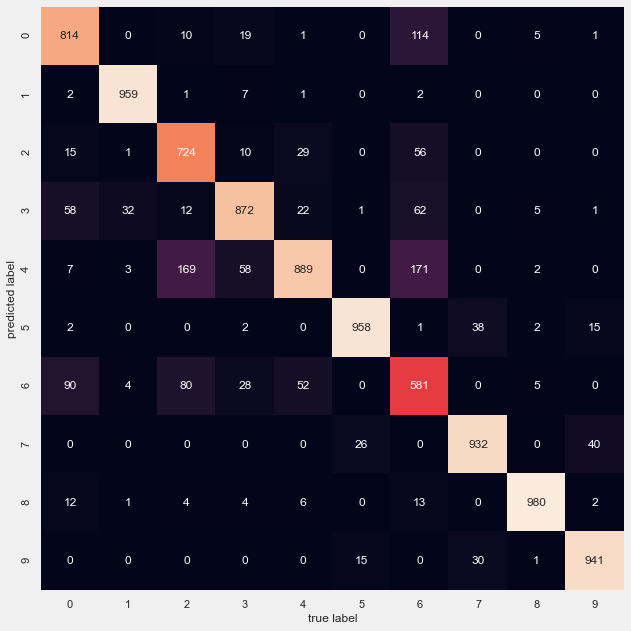

In [89]:
mat = confusion_matrix(y_labels, predict_labels)
plt.figure(figsize=(10, 10))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_labels),
            yticklabels=np.unique(y_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show();

In [90]:
class_report_v = classification_report(predict_labels,y_labels, output_dict=True,target_names=labels_names,zero_division=1)
pd.DataFrame(class_report_v).T

,precision,recall,f1-score,support
T-shirt/top,0.814000,0.844398,0.828921,964.000
Trouser,0.959000,0.986626,0.972617,972.000
Pullover,0.724000,0.867066,0.789101,835.000
Dress,0.872000,0.818779,0.844552,1065.000
Coat,0.889000,0.684373,0.773380,1299.000
Sandal,0.958000,0.941061,0.949455,1018.000
Shirt,0.581000,0.691667,0.631522,840.000
Sneaker,0.932000,0.933868,0.932933,998.000
Bag,0.980000,0.958904,0.969337,1022.000
Ankle boot,0.941000,0.953394,0.947157,987.000


# 7.<span style="color:brown"> Comparaison des modèles </span>

In [91]:
bilan=pd.DataFrame({'Modèles':['DNN_1', 'DNN_2', 'CNN', 'DNN_KT', 'CNN_KT', 'INCEPTION_V3','VGG19'],
                    "Loss":[loss_dnn1,loss_dnn2,loss_cnn,loss_dnn_kt, loss_cnn_kt, loss_v3,loss_vgg19],
                    "Accuracy":[accuracy_dnn1,accuracy_dnn2,accuracy_cnn,accuracy_cnn_kt,
                                accuracy_cnn_kt, accuracy_v3,accuracy_vgg19]})
bilan.set_index("Modèles", inplace=True)

In [92]:
bilan

,Loss,Accuracy
Modèles,,
DNN_1,0.383721,0.8705
DNN_2,0.376255,0.8755
CNN,0.228267,0.9230
DNN_KT,0.399765,0.8838
CNN_KT,0.764916,0.8838
INCEPTION_V3,0.218771,0.9244
VGG19,0.388645,0.8650


# 8.<span style="color:cyan"> XAI </span>

**L'explication des prédictions se fera avec la fonction SamplingExplainer du package SHAP**

**Les prédictions à décomposer seront celles du modèle DNN_2 précédement utilisé**

In [93]:
import shap
#initialize js methods for visualization
shap.initjs()

**On ré-entrainne le modèle DNN_2 sur un dataset réduit à 50 images train ,15 validation et 20 images dans le test afin d'accélèrer l'execution**

In [102]:
X_train = X_train_dnn[:50]
y_train = y_train_dnn[:50]
X_val = X_val_dnn[:15]
y_val = y_val_dnn[:15]
X_test = X_test_dnn[:20]
y_test = y_test_dnn[:20]

In [103]:
%%time
keras.backend.clear_session()

dnn_2.fit(X_train, y_train,
          epochs= nb_epochs,batch_size=64,
          validation_data = (X_val, y_val),
         callbacks = [cb1,cb2])

Epoch 1/15
1/1 [==============================] - 0s 88ms/step - loss: 0.1288 - accuracy: 0.9800 - val_loss: 0.8288 - val_accuracy: 0.8667
Epoch 2/15
1/1 [==============================] - 0s 17ms/step - loss: 0.1098 - accuracy: 0.9800 - val_loss: 0.8447 - val_accuracy: 0.8667
Epoch 3/15
1/1 [==============================] - 0s 19ms/step - loss: 0.0913 - accuracy: 0.9800 - val_loss: 0.8601 - val_accuracy: 0.8667
Epoch 4/15
1/1 [==============================] - 0s 22ms/step - loss: 0.0765 - accuracy: 0.9800 - val_loss: 0.8752 - val_accuracy: 0.8667
Epoch 5/15
1/1 [==============================] - 0s 18ms/step - loss: 0.0648 - accuracy: 0.9800 - val_loss: 0.8894 - val_accuracy: 0.8667
Epoch 6/15
1/1 [==============================] - 0s 20ms/step - loss: 0.0550 - accuracy: 0.9800 - val_loss: 0.9030 - val_accuracy: 0.8667
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping
Wall time: 232 ms


In [104]:
predictions = dnn_2.predict(X_test)
predict_labels = []
for pred in predictions:
    predict_labels.append(np.argmax(pred))

In [105]:
y_labels = []
for pred in y_test:
    y_labels.append(np.argmax(pred))

In [106]:
import pandas as pd

data = pd.DataFrame(X_train, columns = ['Col' + str(i) for i in range(784)])

In [107]:
explainer = shap.SamplingExplainer(dnn_2,data)

In [108]:
%%time

ex = explainer.shap_values(data)

  0%|          | 0/50 [00:00<?, ?it/s]

Wall time: 40min 44s


In [112]:
shap_values = explainer(data)

  0%|          | 0/50 [00:00<?, ?it/s]

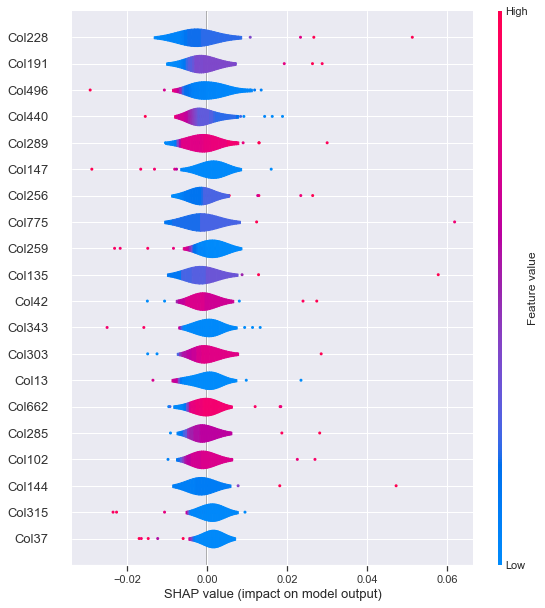

In [121]:
shap.summary_plot(ex[0],data, plot_type="violin")